<font size="6">Computational explanation of probabilistic ELECTRE Tri-B (pELECTRE Tri-B)</font>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/cghiaus/ELECTRE_Tri/main?labpath=docs%2Fexplanation%2Felectre_tri-b_explained.ipynb)

pELECTRE Tri-B is a probabilistic sorting method for multiple-criteria decision-making ([MCDM](https://en.m.wikipedia.org/wiki/Multiple-criteria_decision_analysis)) which estimates probable degree of membership of alternatives to categories. The categories are completely ordered and defined by base (or reference) profiles ([Figueira et al. 2005](https://doi.org/10.1007/0-387-23081-5_4)).

In [3]:
"""
Append `src/` directory to `path`
"""
import sys
import os

notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.dirname(os.path.dirname(notebook_dir))

src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)

In [4]:
import numpy as np
import pandas as pd

import electre_tri as et

pd.options.display.float_format = '{:.2f}'.format
np.random.seed(123)

# Introduction

ELECTRE is a family of **outranking** methods. The relation **"$a$ outranks $b$"** (denoted as $a > b$, $a\, S\, b$, or $a \succ b$) means that there are sufficient arguments to support the claim that **alternative $a$ is at least as good as alternative $b$**, while there are no strong arguments against this claim. In many practical applications, the values of alternatives for each criterion are a guess. Therefore, pELECTRE Tri uses statistical (e.g., normal) distribution for the values of alternatives in the decision matrix.

## Assumptions

1. The set of categories to which the alternatives must be assigned to is completely ordered (from the worst to the best, from the lowest to the highest priority, from the  riskiest to the safest, etc.).
2. Each category is defined to receive alternatives (or actions), which are processed in the same way.
3. Each category is defined by two reference alternatives, which represent its lower and upper bounds, called boundary reference alternatives, boundary actions or base profiles. The lower base profile of a better category is also the upper base profile of the worse consecutive category.
4. Each alternative is characterized by mean value and standard deviation for each criterion.

## Definitions
  
### Input data

- **Criteria** $c = \{c_k\}$ are the different factors or attributes used to evaluate the alternatives in the decision making process. The criteria can be maximised (e.g. efficiency, savings) or minimised (e.g. cost, environmental impact).

- **Alternatives** are the options or items being evaluated and sorted into categories. These represent the decision objects that need to be classified according to multiple criteria. The alternatives are characterized by the performance matrix and standard deviations matrix:
    - **Performance matrix** $A = \{a_{i,k}\}$ with $i=0,\ldots,n-1$ and $k=0,\ldots,m-1$, where $i$ is the index of alternatives and $k$ is the index of criteria $c_k$ are the __mean__ values of alternatives. The performance values in the criteria with a decreasing preference direction, i.e. that need minimization, are multiplied by "-1". Thus, these criteria will also get an increasing performance direction, i.e. require maximization.

    - **Standard deviations of alternnatives** is a matrix $S = \{s_{i,k}\}$ of the shape of performance matrix $A = \{a_{i,k}\}$ containing the standard deviation of each alternative for each criterion.

- **Base profiles** (boundary reference actions, boundary actions, or reference profiles) define the boundaries between the predefined ordered **categories**. The base profiles form a matrix: $B = \{b_{j,k}\}$ with $j=0,\ldots,l-1$ and $k=0,\ldots,m-1$, where $j$ is the index of base profile and $k$ is the index of criteria. The base profile values for criteria with a decreasing preference direction will be multiplied by "-1".

- **Thresholds** account for uncertainty and imprecision of alternatives and base profiles. Thresholds form a matrix  $T = \{t_{j,k}\}$, where $k$ is the index of the criteria and $j=\{q, p, v\}$ are the vectors:

    - *indifference* $q = \{q_k \}$ : The largest difference in performance on a criterion that a decision maker considers negligible.
    - *preference* $p = \{p_k\}$ : The smallest difference in performance on a criterion that is considered significant for a clear preference.
    - *veto* $v = \{v_k\}$ : A difference in performance so large that it can negate any outranking relationship indicated by other criteria; the relation $q_k \leq p_k \leq v_k$ holds for each criterion $k.$

- **Criteria weights** $w = \{w_k\}$  represent the relative importance of each criterion in the decision-making process.

- **Credibility threshold** $\lambda$ is a cutting level value that determines whether the outranking relation between an alternative and a base profile is considered valid or not. It is usually set within the range of 0.5 to 1 (typically 0.75).

### Results

- **Probabilistic classficiation** is a matrix that indicates for each alternative the degree of membership (between `0` and `1`) to each category.

# Problem statement for pELECTRE Tri MCDM

Probabilistic ELECTRE Tri-B is a multiple-criteria decision-making (MCDM) method designed to give the membership value  of alternatives to predefined ordered categories by executing Monte Carlo simulations of ELECTRE Tri-B sorting. 

The problem it addresses can be stated as:

**Given:**
- A set of criteria $c = \{c_k\}$ with associated weights $w = \{w_k\}$.
- A matrix $A = \{a_{i,k}\}$ of performances of alternatives $a_i$ for each criterion $k$.
- A matrix $S = \{s_{i,k}\}$ of standard deviation of performances of alternatives $a_i$ for each criterion $k$.
- A matrix $B = \{b_{j,k}\}$ of base profiles (or category boundaries) $b_j$ for each criterion $k$ that form a set of $l$ ordered categories $C$, where $l - 1$ is the number of base profiles.
- Preference $p = \{p_k\}$, indifference $q = \{q_k\}$, and veto $v = \{v_k\}$ threshold vectors for each criterion.
- A credibility threshold $\lambda$ for outranking.


**Do:**

1. Take random values for performance of alternatives with mean $\{a_{i,k}\}$ and standard deviation $\{s_{i,k}\}$.
2. Assign each alternative $a_i ∈ A$ to one of the predefined categories $C_j ∈ C$ based on its performance across all criteria $c_k$ by using optimistic and pessimistic classification.
3. Repeat steps 1 and 2.
4. Obtain probabilistic classification that shows the probability of each alternative to belong to a category.

# Problem inputs: example

The alternatives (A) and their standard deviations (S), base profiles (B), thersholds (T) matrices and the weights (w) vector can be gouped in a `.csv` data file.

In [11]:
# Problem inputs
data_file = '../../data/mous3docl99_3_std.csv'
credibility_threshold = 0.7

In [12]:
pd.read_csv(data_file)

,type,profile,c1,c2,c3,c4,c5
0,A,a1,75.00,67.00,85.00,82.00,90.00
1,A,a2,28.00,35.00,70.00,90.00,95.00
2,A,a3,45.00,60.00,55.00,68.00,60.00
3,S,s1,7.50,6.70,8.50,8.20,9.00
4,S,s2,2.80,3.50,7.00,9.00,9.50
5,S,s3,4.50,6.00,5.50,6.80,6.00
6,B,b1,50.00,48.00,55.00,55.00,60.00
7,B,b2,70.00,75.00,80.00,75.00,85.00
8,T,q,5.00,5.00,5.00,5.00,5.00
9,T,p,10.00,10.00,10.00,10.00,10.00


Note that the values of standard deviations (matrix $S$) are _fabricated_ as 10 % of the mean value.

# Problem statement: example

__Given:__
- A set of five criteria $c = \{c_k\}$ with associated weights $w = \{w_k\}$.
- A matrix $A = \{a_{i,k}\}$ of performances of three alternatives $a_i$ for each criterion $k$.
- A matrix $S = \{s_{i,k}\}$ of standard deviation of performances of alternatives $a_i$ for each criterion $k$.
- A matrix $B = \{b_{j,k}\}$ of two base profiles (or category boundaries) $b_j$ for each criterion $k$ that form a set of 3 ordered categories $C$:
  - __b1 >__: alternative does not outrank the lowest base profile, $b_1 ≻ a_i$;
  - __(b1, b2)__: alternative is between __b1__ and __b2__, $b_1 ≺ a_i ≺ b_2$ 
  - __b2 <__: alternative outranks the highest base profile, $b_2 ≺ a_i$;
- A matrix $T$ of preference $p = \{p_k\}$, indifference $q = \{q_k\}$, and veto $v = \{v_k\}$ threshold vectors for each criterion.
- A credibility threshold $\lambda$ for outranking.

__Do:__

For each alternative $a_i ∈ A$, give the probability of being in one of the predefined categories $C$:
1. __b1 ≻__, i.e. $P(a_i ≺ b_1)$
2. __(b1, b2)__, i.e. $P(b_1 ≺ a_i ≺ b_2)$
3. __b2 ≺__, i.e. $P(b_2 ≺ a_i)$ 

# Problem solving

Given:
- criteria to maximize; 
- alternatives, __A__, standard deviations, __S__, and increasing base profiles, __B__;
- thresholds (preference, indifference, and veto), __T__;
- weights, __w__;
- credibility threshold, λ.

Perform:
1. Generate random samples from normal distributions for each value in the performance matrix A;
2. Run the ELECTRE Tri-B method on each sample of A by using:
    - optimistic (ascending) classification;
    - pessimistic (descending) classification.

3. Repeat steps 1 & 2.
4. Aggregate the results to get probabilities of assignment of each alternative to each category.

In [16]:
# Problem solving
A, S, B, T, w = et.read_pelectre_tri_base(data_file)

opti, pessi = et.electre_tri_b(A, B, T, w,
                               credibility_threshold)

p_opti, p_pessi = et.pelectre_tri_b(
    A, S, B, T, w,
    credibility_threshold,
    n_simulations=100)

# Results

The results consist in classification matrix composed of categories (on rows) and alternatives (on columns).

## ELECTRE Tri-B classification

In ELECTRE Tri-B classification, each altenative belongs to one and only one category, shown by `1`. 

In [18]:
# Results
print("\nOptimistic ranking:")
print(opti.to_string(na_rep='0'))

print("\nPessimistic ranking:")
print(pessi.to_string(na_rep='0'))


Optimistic ranking:
           a1   a2   a3
b1 ≻        0    0    0
(b1, b2)    0    0 1.00
b2 ≺     1.00 1.00    0

Pessimistic ranking:
           a1   a2   a3
b1 ≻        0 1.00    0
(b1, b2) 1.00    0 1.00
b2 ≺        0    0    0


## pELECTRE Tri-B classification

In probabilistic ELECTRE Tri-B classification, an alternative has different probabilities of belonging to different categories. The sum of probabilites on a column is `1`.

In [20]:
# Results
print("\nProbabilistic optimistic ranking:")
print(p_opti.to_string(na_rep='0'))

print("\nProbabilistic pessimistic ranking:")
print(p_pessi.to_string(na_rep='0'))


Probabilistic optimistic ranking:
           a1   a2   a3
b1 ≻        0    0    0
(b1, b2) 0.13 0.47 1.00
b2 ≺     0.87 0.53    0

Probabilistic pessimistic ranking:
           a1   a2   a3
b1 ≻        0 0.95 0.41
(b1, b2) 0.55 0.05 0.59
b2 ≺     0.45    0    0


## Comparison between crisp and probabilistic classifictions



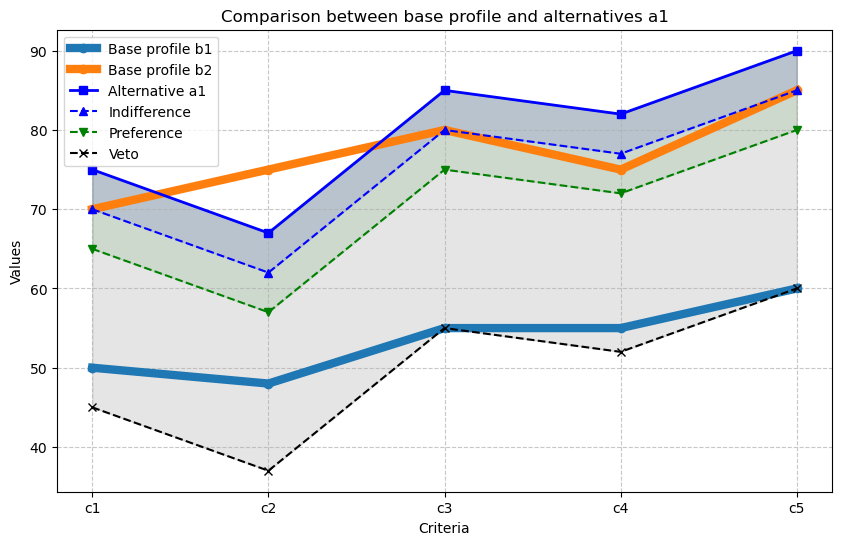

In [22]:
et.plot_base_profiles_vs_alternative(B, A.iloc[0], T)

Alternative __a1__

| Category | Optimistic | classification|
|:---------|-----------:|:--------------|
|          | Crisp      | Probabilistic|
| b1 >     | 0          |$P(a_1 ≺ b_1) = 0$|
| (b1, b2) | 0          |$P(b_1 ≺ a_1 ≺ b_2) = 0.13$|
| b2 <     | 1          |$P(b_2 ≺ a_1) = 0.87$|


| Category | Pessimistic| classification|
|:---------|-----------:|:--------------|
|          | Crisp      | Probabilistic|
| b1 >     | 0          |$P(a_1 ≺ b_1) = 0$|
| (b1, b2) | 1          |$P(b_1 ≺ a_1 ≺ b_2) = 0.55$|
| b2 <     | 0          | $P(b_2 ≺ a_1) = 0.45$|

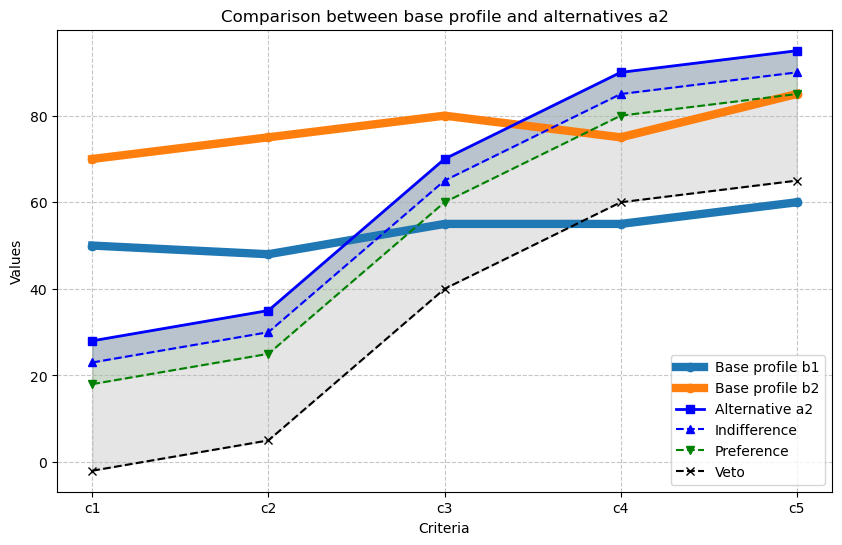

In [24]:
et.plot_base_profiles_vs_alternative(B, A.iloc[1], T)

Alternative __a2__:

| Category | Optimistic | classification|
|:---------|-----------:|:--------------|
|          | Crisp      | Probabilistic|
| b1 >     | 0          |$P(a_1 ≺ b_1) = 0$|
| (b1, b2) | 0          |$P(b_1 ≺ a_1 ≺ b_2) = 0.47$|
| b2 <     | 1          |$P(b_2 ≺ a_1) = 0.53$|


| Category | Pessimistic| classification|
|:---------|-----------:|:--------------|
|          | Crisp      | Probabilistic|
| b1 >     | 1          |$P(a_1 ≺ b_1) = 0.95$|
| (b1, b2) | 0          |$P(b_1 ≺ a_1 ≺ b_2) = 0.05$|
| b2 <     | 0          | $P(b_2 ≺ a_1) = 0$|


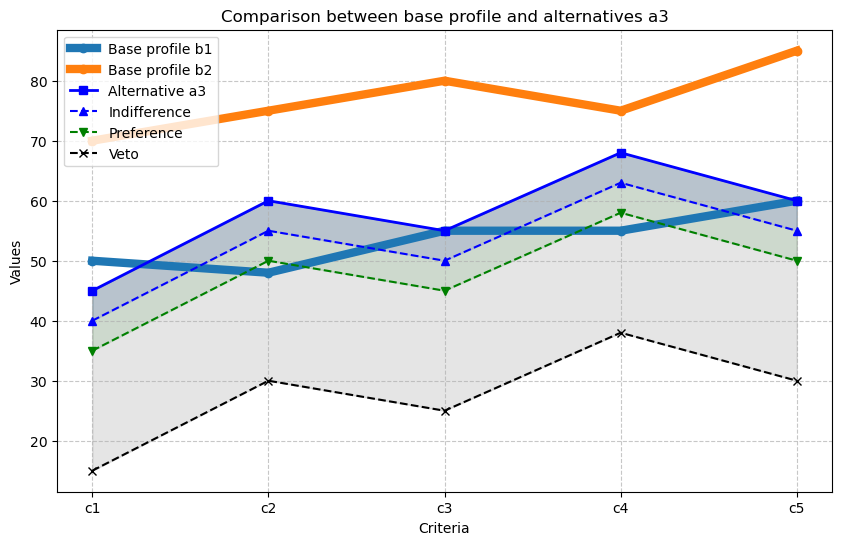

In [26]:
et.plot_base_profiles_vs_alternative(B, A.iloc[2], T)

Alternative __a3__:

| Category | Optimistic | classification|
|:---------|-----------:|:--------------|
|          | Crisp      | Probabilistic|
| b1 >     | 0          |$P(a_1 ≺ b_1) = 0$|
| (b1, b2) | 1          |$P(b_1 ≺ a_1 ≺ b_2) = 1$|
| b2 <     | 0          |$P(b_2 ≺ a_1) = 0$|


| Category | Pessimistic| classification|
|:---------|-----------:|:--------------|
|          | Crisp      | Probabilistic|
| b1 >     | 0          |$P(a_1 ≺ b_1) = 0.41$|
| (b1, b2) | 1          |$P(b_1 ≺ a_1 ≺ b_2) = 0.59$|
| b2 <     | 0          | $P(b_2 ≺ a_1) = 0$|


# References

Baseer, M., Ghiaus, C., Viala, R., Gauthier, N., & Daniel, S. (2023).
pELECTRE-Tri: Probabilistic ELECTRE-Tri Method—Application for the
Energy Renovation of Buildings. Energies, 16(14), 5296.
https://doi.org/10.3390/en16145296

Baseer, M. (2024). Multi-criteria decision making for sustainable engineering systems, PhD thesis INSA de Lyon, 2023. 

Gauthier, N., Viala, R. (2023). pELECTRE-Tri: Probabilistic ELECTRE-Tri method - application to energy renovation of buildings. Zenodo. https://doi.org/10.5281/zenodo.7967656

Daniel, S., Ghiaus, C. (2023). ELECTRE Tri-B MCDA : an object oriented multi-criteria decision analysis tool in Python (2.0.0). Zenodo. https://doi.org/10.5281/zenodo.6394320